In [143]:
import os
from PIL import Image 
import random
import numpy as np
import pickle
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.notebook import tqdm

from keras import backend as k
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator ,img_to_array
from keras.models import Sequential,Model
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,AveragePooling2D,Dropout,BatchNormalization,Activation
from keras.activations import relu,softmax
from keras.initializers import he_normal,glorot_normal,random_normal,glorot_uniform
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta,Adam
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**0.Visualizing some train samples**

In [140]:
def plot_sample_images(train_path):

  train_gen = ImageDataGenerator().flow_from_directory(
      directory = train_path,
      color_mode = 'rgb',
      class_mode = 'categorical'
  )

  cls = train_gen.classes
  dict1 = train_gen.class_indices
  idx_to_class = {v:k for k,v in dict1.items()}
  paths = train_gen.filepaths
  tot_images = len(paths)
  sampled_class = [0]*10
  count =0
  
  ix = 1 
  plt.figure(figsize = (15,8))
  while count!=10:
    i = random.randrange(0,tot_images+1)
    cls_i = cls[i]

    if sampled_class[cls_i]==0:
      img = load_img(paths[i] ,target_size = (256,256))
      ax = plt.subplot(2,5,ix)
      ax.set_xticks([]);ax.set_yticks([]);ax.set_title(idx_to_class[cls_i])
      plt.imshow(img)
      ix+=1
      sampled_class[cls_i] = 1
      count+=1

  plt.suptitle('sample images from train.')  
  plt.show()
  return


Found 9999 images belonging to 10 classes.


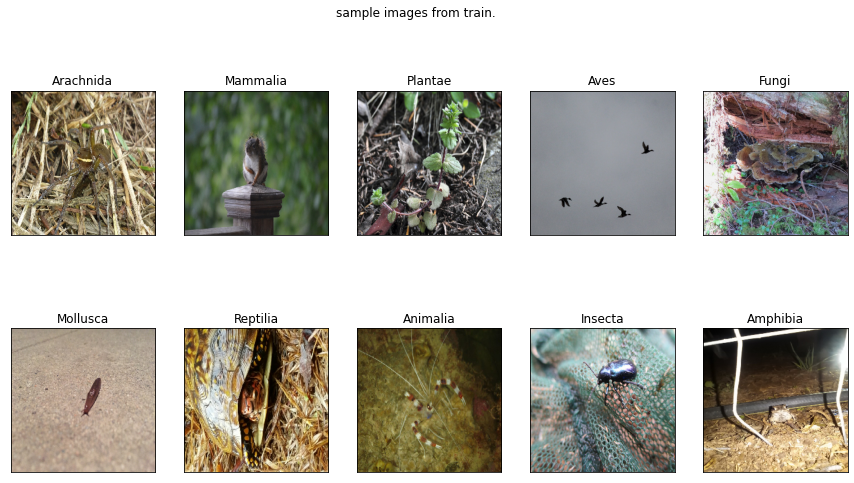

In [141]:
train_path = '/content/gdrive/MyDrive/inaturalist_12K/train'
plot_sample_images(train_path)

**Q.2. Hyperparameter tuning on 10% of Data**

In [4]:
class CNN_M:

  def __init__(self,input_shape,target_size ,num_filters,filter_size,fo,num_neurons,data_aug,dropout,BN,num_outputs):
    self.model = Sequential()
    self.input_shape = input_shape
    self.target_size = target_size
    self.num_filters = num_filters
    self.filter_size = filter_size
    self.fo = fo
    self.num_neurons =num_neurons
    self.data_aug = data_aug
    self.dropout = dropout
    self.BN = BN
    self.num_outputs = num_outputs

  def BUILD_MODEL(self):
    
    #Build 1st layer...
    self.model.add(Conv2D(filters = self.num_filters ,kernel_size =self.filter_size,use_bias = True,
                          input_shape=self.input_shape))
    self.model.add(Activation('relu'))
    self.model.add(MaxPooling2D(pool_size=(2,2)))

    cf = self.num_filters 
    for i in range(1,5):
      cf*=self.fo
      self.model.add(Conv2D(filters = cf , kernel_size = self.filter_size ,use_bias= True))
      if self.BN == 'Yes':
        self.model.add(BatchNormalization(axis = -1))

      self.model.add(Activation('relu'))
      self.model.add(Dropout(self.dropout))
      self.model.add(MaxPooling2D(pool_size=(2,2)))

    self.model.add(Flatten())
    self.model.add(Dense(units=self.num_neurons))
    
    if self.BN == 'Yes':
      self.model.add(BatchNormalization(axis = -1))
    
    self.model.add(Activation('relu'))
    self.model.add(Dropout(self.dropout))

    self.model.add(Dense(units = self.num_outputs ,activation='softmax'))

    self.model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return 


  #Fit model using the train datagenerator and returns fitted model..
  def fit_CNN(self , train_path ,epochs ,batch_size):

    if self.data_aug == 1:
      tr_datagen = ImageDataGenerator(rescale=1./255,validation_split = 0.1,
                                      zoom_range=0.2 ,horizontal_flip=True ,rotation_range=30 ,shear_range=12)
    else:
      tr_datagen = ImageDataGenerator(rescale=1./255,
                             validation_split = 0.1)
    
    tr_gen = tr_datagen.flow_from_directory(
        directory = train_path,target_size = self.target_size,color_mode = 'rgb',       
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True,
        seed = 10,
        subset = 'training'
        )

    val_gen = tr_datagen.flow_from_directory(
        directory = train_path,target_size = self.target_size,color_mode = 'rgb',
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True,
        seed = 10,
        subset = 'validation'
        ) 
      
    #Fitting The model...
    step_size_train = tr_gen.n//tr_gen.batch_size
    step_size_valid = val_gen.n//val_gen.batch_size

    self.model.fit_generator(generator = tr_gen,
                             steps_per_epoch = step_size_train,
                             validation_data = val_gen,
                             validation_steps = step_size_valid,
                             epochs = epochs, verbose=1)
                             #callbacks = [WandbCallback(monitor='val_accuracy',
                                                   #save_model = True)])
    return 

In [ ]:
!pip install wandb -qqq
import wandb
wandb.login()

     |████████████████████████████████| 2.1MB 14.3MB/s 
     |████████████████████████████████| 133kB 49.6MB/s 
     |████████████████████████████████| 163kB 44.9MB/s 
     |████████████████████████████████| 102kB 10.5MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import wandb
from wandb.keras import WandbCallback

In [ ]:
sweep_config = {
  'name': 'A2.QA',
  'method': 'grid',
  'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
  'parameters': {
        'num_filters': {
            'values': [32,64]
        },
        'fo':{
            'values':[0.5,1,2]
        },
        'data_aug':{
            'values':[0,1]
        },
        'dropout':{
            'values':[0.2,0.3]
        },
        'BN':{
            'values':['Yes','No']
        }

    }
}

sweep_id = wandb.sweep(sweep_config, project='A2.QA', entity='abhisheknegi_cs20m008')

Create sweep with ID: ghtb8z86
Sweep URL: https://wandb.ai/abhisheknegi_cs20m008/A2.QA/sweeps/ghtb8z86


In [ ]:
def train():
  run = wandb.init()
  configuration=run.config

  target_size = (256,256)
  if k.image_data_format()=='channels_first':
    input_shape = (3,tsize,tsize)

  else:
    input_shape = (tsize,tsize,3)

  train_path = '/content/gdrive/MyDrive/inaturalist_12K_subset/train'

  epochs =10
  batch_size =32
  cnn = CNN_M(input_shape = input_shape,
            target_size = target_size,
            num_filters = configuration.num_filters,
            filter_size =3,
            fo = configuration.fo,
            num_neurons = 64,
            data_aug = configuration.data_aug,
            dropout = configuration.dropout,
            BN = configuration.BN,
            num_outputs = 10)
  
  cnn.BUILD_MODEL()
  cnn.fit_CNN(train_path,epochs=epochs,batch_size=batch_size)

#train()
wandb.agent(sweep_id=sweep_id, function=train)

wandb: Agent Starting Run: ig3bl94m with config:
wandb: 	BN: No
wandb: 	data_aug: 0
wandb: 	dropout: 0.3
wandb: 	fo: 2
wandb: 	num_filters: 64
wandb: Currently logged in as: abhisheknegi_cs20m008 (use `wandb login --relogin` to force relogin)


Found 901 images belonging to 10 classes.
Found 99 images belonging to 10 classes.
Epoch 1/10
28/28 [==============================] - 664s 23s/step - loss: 3.7534 - accuracy: 0.0663 - val_loss: 2.3027 - val_accuracy: 0.1042
Epoch 2/10
 6/28 [=====>........................] - ETA: 5:34 - loss: 2.3069 - accuracy: 0.0865

wandb: Ctrl + C detected. Stopping sweep.


In [7]:
#target size of image..
tsize = 256
target_size = (tsize,tsize)
if k.image_data_format()=='channels_first':
  input_shape = (3,tsize,tsize)

else:
  input_shape = (tsize,tsize,3)

train_path = '/content/gdrive/MyDrive/inaturalist_12K_subset/train'

epochs =10
batch_size =32
cnn = CNN_M(input_shape = input_shape,
            target_size = target_size,
            num_filters = 32,
            filter_size =3,
            fo = 1,
            num_neurons = 64,
            data_aug = 1,
            dropout = 0.2,
            BN = 'Yes',
            num_outputs = 10)
  
cnn.BUILD_MODEL()
cnn.fit_CNN(train_path,epochs=epochs,batch_size=batch_size)

Found 1800 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
Epoch 1/10
56/56 [==============================] - 695s 12s/step - loss: 2.4549 - accuracy: 0.1376 - val_loss: 2.3679 - val_accuracy: 0.0990
Epoch 2/10
56/56 [==============================] - 181s 3s/step - loss: 2.1560 - accuracy: 0.2319 - val_loss: 2.4231 - val_accuracy: 0.1042
Epoch 3/10
56/56 [==============================] - 181s 3s/step - loss: 2.0589 - accuracy: 0.2577 - val_loss: 2.4981 - val_accuracy: 0.0938
Epoch 4/10
56/56 [==============================] - 181s 3s/step - loss: 2.0427 - accuracy: 0.2792 - val_loss: 2.5012 - val_accuracy: 0.1042
Epoch 5/10
56/56 [==============================] - 181s 3s/step - loss: 1.9997 - accuracy: 0.2858 - val_loss: 2.5832 - val_accuracy: 0.0938
Epoch 6/10
56/56 [==============================] - 181s 3s/step - loss: 1.9333 - accuracy: 0.3099 - val_loss: 2.5342 - val_accuracy: 0.1042
Epoch 7/10
56/56 [==============================] - 181s 3s/step - l

**Q3.Based on the above plots write down some insightful observations.**

**Q.4.You will now apply your best model on the test data (You shouldn't have used test data so far. All the above experiments should have been done using train and val data only).**

In [ ]:
#cnn.model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

# returns a compiled model
# identical to the previous one
#model = load_model('my_model.h5')

In [59]:
#Return the accuracy and predictions on test data ..

test_path = '/content/gdrive/MyDrive/inaturalist_12K_subset/val'
ts_datagen = ImageDataGenerator(rescale = 1./255)
test_gen = ts_datagen.flow_from_directory(
    directory = test_path,
    target_size = (256,256),
    color_mode = 'rgb',
    batch_size = 1,
    class_mode = None,
    shuffle = False,
    seed=10
    )
    
step_size_test = test_gen.n//test_gen.batch_size
test_gen.reset()

pred = cnn.model.predict_generator(generator = test_gen,
                                  steps = step_size_test,
                                  verbose = 1
                                  )
    
ypred = np.argmax(pred,axis=1)
ytrue = test_gen.classes 


Found 346 images belonging to 10 classes.
346/346 [==============================] - 12s 34ms/step


**Q.4.a use the best model and report accuracy on test data**

In [60]:
print("Test accuracy", np.sum(ypred == ytrue)/len(ytrue))

Test accuracy 0.11849710982658959


**Q.4.b.Provide a 10 x 3 grid containing sample images from the test data and predictions made by your best model (more marks for presenting this grid creatively).**

In [61]:
dict1 = test_gen.class_indices
idx_to_class = {v:k for k,v in dict1.items()}

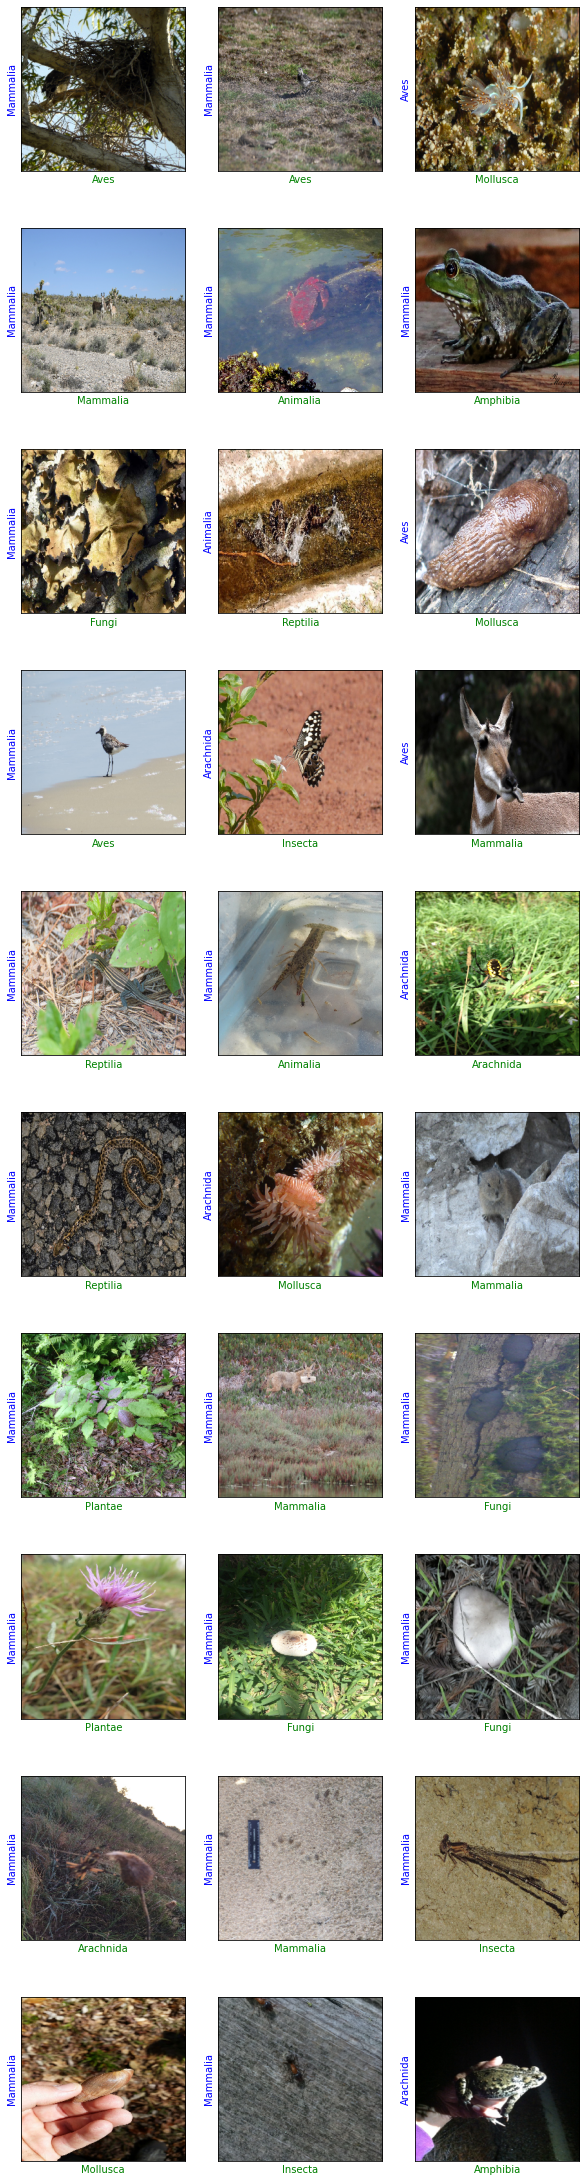

In [79]:
from keras.preprocessing.image import load_img

random.seed(10)
test_image_paths = test_gen.filepaths
rnd_idx = np.random.choice(len(test_image_paths),30,replace=False)
ix=1
plt.figure(figsize=(10,40))
for idx in rnd_idx:
  ax = plt.subplot(10,3,ix)
  img = load_img(test_image_paths[idx],target_size=(256,256))
  ax.set_xticks([])
  ax.set_yticks([])
  true_label = idx_to_class[ytrue[idx]]
  pred_label = idx_to_class[ypred[idx]]

  ax.set_xlabel(true_label);ax.xaxis.label.set_color('green')
  ax.set_ylabel(pred_label);ax.yaxis.label.set_color('blue')

  plt.imshow(img)

  ix+=1
plt.show()


**Q4.c.Visualise all the filters in the first layer of your best model for a random image from the test set. If there are 64 filters in the first layer plot them in an 8 x 8 grid.**

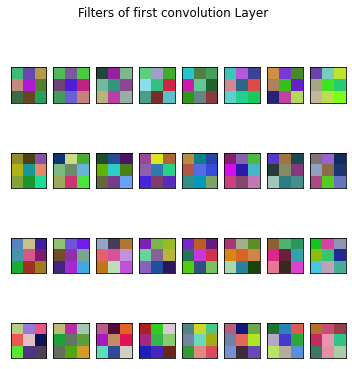

In [16]:
filters , biases = cnn.model.layers[0].get_weights()
f_min , f_max = filters.min() , filters.max()

filters = (filters - f_min)/(f_max - f_min)
n_filters ,ix = 32 ,1
#4x8 grid
plt.figure(figsize = (6,6))
for i in range(n_filters):
   f = filters[:,:,:,i]
   ax = plt.subplot(4,8,ix)
   ax.set_xticks([])
   ax.set_yticks([])
   plt.imshow(f)
   ix+=1

plt.suptitle("Filters of first convolution Layer")
plt.show()

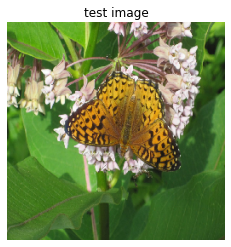

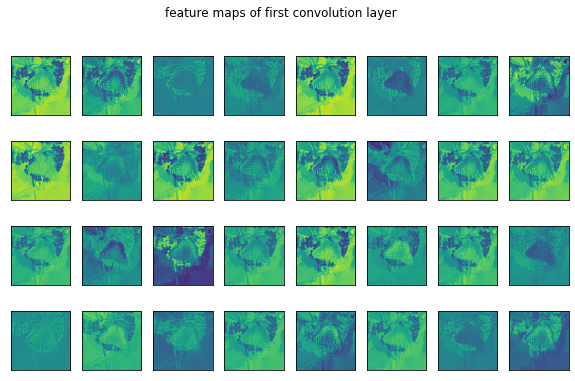

In [142]:
#feature Map for first convolution layer..
output_layer1 = cnn.model.layers[0].output
fmodel = Model(inputs = cnn.model.inputs , outputs = output_layer1)

ts_img = load_img(test_image_paths[189],target_size=(256,256))
plt.imshow(ts_img)
plt.axis('off')
plt.title('test image')
ip_img = img_to_array(ts_img)
ip_img = ip_img.reshape((1,)+ip_img.shape)
ip_img/=255.0

fmaps = fmodel.predict(ip_img)
num_fmaps = fmaps.shape[3]
ix = 1
plt.figure(figsize = (10,6))
for i in range(num_fmaps):

   ax = plt.subplot(4,8,ix)
   ax.set_xticks([])
   ax.set_yticks([])
   plt.imshow(fmaps[0,:,:,ix-1])
   ix+=1

plt.suptitle("feature maps of first convolution layer")
plt.show()